In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import re
from tqdm import tqdm


In [3]:
orig_matrix = pd.read_csv('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Dan/mutation_matrix.csv', sep='\t', index_col=0)
orig_matrix


,TCGA-4P-AA8J,TCGA-BA-4074,TCGA-BA-4075,TCGA-BA-4076,TCGA-BA-4077,TCGA-BA-4078,TCGA-BA-5149,TCGA-BA-5151,TCGA-BA-5152,TCGA-BA-5153,...,TCGA-UF-A7JH,TCGA-UF-A7JJ,TCGA-UF-A7JK,TCGA-UF-A7JO,TCGA-UF-A7JS,TCGA-UF-A7JT,TCGA-UF-A7JV,TCGA-UP-A6WW,TCGA-WA-A7GZ,TCGA-WA-A7H4
_96_class,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,3.0,3.0,1.0,10.0,9.0,13.0,1.0,2.0,6.0,0.0,...,0.0,1.0,2.0,1.0,2.0,2.0,0.0,1.0,4.0,0.0
A[C>A]C,1.0,0.0,0.0,7.0,0.0,8.0,1.0,1.0,0.0,0.0,...,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
A[C>A]G,3.0,1.0,1.0,12.0,2.0,12.0,0.0,0.0,1.0,1.0,...,0.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A[C>A]T,0.0,1.0,0.0,8.0,0.0,4.0,1.0,1.0,0.0,0.0,...,1.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
A[C>G]A,5.0,1.0,2.0,4.0,22.0,10.0,4.0,0.0,42.0,0.0,...,0.0,1.0,0.0,7.0,4.0,13.0,5.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T[T>C]T,2.0,2.0,5.0,3.0,1.0,3.0,2.0,1.0,0.0,0.0,...,0.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,4.0,0.0
T[T>G]A,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
T[T>G]C,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

base_sig = '/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature'
base_exp = '/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure'
dims     = [f'dim_{d}' for d in range(2,26)]

# If you still want to collect all M_hats in a nested dict, you can.
# But note this will still grow large. Prefer to compute & discard or
# reduce to summaries (errors, stabilities) as you go.
M_hats = {}
KL_scores = {}
forbenious = {}
cos_scores  = {} 

for dim in tqdm(dims):
    sig_dir = os.path.join(base_sig, dim)
    exp_dir = os.path.join(base_exp, dim)
    
    # sorted lists of filenames
    sig_files = sorted(f for f in os.listdir(sig_dir) if f.endswith('.csv'))
    exp_files = sorted(f for f in os.listdir(exp_dir) if f.endswith('.csv'))
    
    # assume they align one-to-one by sort order
    runs = min(len(sig_files), len(exp_files))
    kl_list = []
    frob_list = [] 
    cos_list = []
    M_hats_dim = {}
    
    for run_idx in range(runs):
        # read one Signature file
        sig_fn = sig_files[run_idx]
        S_r = pd.read_csv(os.path.join(sig_dir, sig_fn),
                          index_col=0)
        # tag its columns
        run_label = f"_run_{run_idx+1}"
        S_r.columns = [c+run_label for c in S_r.columns]
        
        # read one Exposure file
        exp_fn = exp_files[run_idx]
        A_r = pd.read_csv(os.path.join(exp_dir, exp_fn),
                          index_col=0)
        # exposure is a row per signature, so tag the index
        A_r.index = [idx+run_label for idx in A_r.index]
        
        # now pick the same run columns/rows
        sig_cols = S_r.columns.tolist()      # k of them
        # A_r.loc picks those rows and leaves samples as columns
        A_rr     = A_r.loc[sig_cols]         # shape (k, n_samples)
        
        # reconstruct
        M_hat = S_r.dot(A_rr)          # contexts × samples
        
        # compute KL divergence: sum_{i,j} [M log(M/Mhat) - M + Mhat]
        eps    = 1e-15
        M_safe    = orig_matrix + eps
        Mhat_safe = M_hat       + eps
        
        kl_matrix = (M_safe * np.log(M_safe / Mhat_safe)
                     - M_safe
                     + Mhat_safe)
        kl_value  = kl_matrix.values.sum()
        kl_list.append(kl_value)
        # compute Frobenius norm ||M - M_hat||_F
        diff    = (orig_matrix - M_hat).values
        frob    = np.linalg.norm(diff, ord='fro')
        frob_list.append(frob)
        
        sims = cosine_similarity(orig_matrix.T, M_hat.T)
        # extract diagonal (each sample vs. its reconstruction)
        per_samp = 1 - np.diag(sims)
        cos_list.append(per_samp.mean())
        
        # discard per‐run arrays before next iteration
        del S_r, A_r, A_rr, M_hat, kl_matrix
        
    # store average KL for this dim
    KL_scores[dim] = float(np.mean(kl_list))
    forbenious[dim]   = float(np.mean(frob_list))
    cos_scores[dim]    = float(np.mean(cos_list))
    M_hats[dim] = M_hats_dim


  0%|          | 0/24 [00:00<?, ?it/s]

In [43]:
# list all files under /Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature/dim_2/
dims = ['dim_' + str(dim) for dim in list(range(2, 26))] 
df_dims = {}

for dim in dims: 
    # get all files in the directory
    path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature', dim)
    exposure_path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure', dim)
    files = os.listdir(path)
    
    # filter for only .csv files
    csv_files = [f for f in files if f.endswith('.csv')]
    
    # create a list to hold the dataframes
    dfs = []
    
    # loop through the csv files and read them into dataframes
    count = 1
    for file in csv_files:
        df = pd.read_csv(os.path.join(path, file), index_col=0)
        df.columns = [col + '_run_' + str(count) for col in df.columns]  # replace spaces with underscores
        count += 1
        dfs.append(df)
    
    # concatenate the dataframes into one dataframe
    combined_df = pd.concat(dfs, axis = 1)
    df_dims[dim] = combined_df


In [44]:
from sklearn.metrics        import silhouette_score
from scipy.spatial.distance import cdist
from scipy.optimize         import linear_sum_assignment
import numpy as np
import pandas as pd

# df_dims: your dict dim→S_df (contexts × (k×100 run‐cols))
final_centroids = {}
sil_scores      = {}

for dim, S_df in df_dims.items():
    # how many signatures
    k = int(dim.split('_')[1])
    
    # pull out the run IDs from the column names
    runs = sorted({c.rsplit('_run_',1)[1] for c in S_df.columns}, key=int)
    
    # collect each run's k signature vectors as an array (k × m)
    per_run = []
    for r in runs:
        cols = [c for c in S_df.columns if c.endswith(f'_run_{r}')]
        per_run.append(S_df[cols].T.values)  # shape (k, m_contexts)
    
    # pick run#1 as reference
    ref     = per_run[0]   # (k, m)
    aligned = [ref]
    
    # align runs 2..100 back to that reference
    for cent in per_run[1:]:
        C        = cdist(ref, cent, metric='cosine')   # (k × k)
        _, cols  = linear_sum_assignment(C)
        aligned.append(cent[cols])                     # reorder cent
    
    # now aligned is a list of 100 arrays each (k, m)
    aligned = np.stack(aligned, axis=0)               # (100, k, m)
    n_runs, _, m = aligned.shape
    
    # 1) silhouette on the flattened replicates
    X      = aligned.reshape(n_runs*k, m)             # (100*k, m)
    labels = np.tile(np.arange(k), n_runs)            # (100*k,)
    sil    = silhouette_score(X, labels, metric='cosine')
    sil_scores[dim] = sil
    
    # 2) average to get final consensus (k, m)
    consensus = aligned.mean(axis=0)
    final_centroids[dim] = pd.DataFrame(
        consensus.T,                                  # m_contexts × k
        index=S_df.index,
        columns=[f"Sig_{i+1}" for i in range(k)]
    )


In [45]:
cluster_centroids = {}

for dim in df_dims.keys():
    kmeans = KMeans(n_clusters=int(dim.split('_')[1]))
    kmeans.fit(df_dims[dim].T) 
    cluster_centroids[dim] = kmeans.cluster_centers_


In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

cluster_centroids = {}
cluster_stability = {}
silhouette = {}

for dim, df in df_dims.items():
    k = int(dim.split('_')[1])
    X = df.T                              # shape = (n_runs, 96)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    centroids = kmeans.cluster_centers_   # shape = (k, 96)

    labels = kmeans.labels_
    sil_vals = silhouette_samples(X, labels)
    stability = {i: sil_vals[labels==i].mean()
                 for i in range(k)}

    cluster_centroids[dim] = centroids
    cluster_stability[dim] = stability

    print(f"{dim}: overall silhouette = {silhouette_score(X, labels):.3f}")
    silhouette[dim] = silhouette_score(X, labels)


dim_2: overall silhouette = 0.811
dim_3: overall silhouette = 0.708
dim_4: overall silhouette = 0.504
dim_5: overall silhouette = 0.424
dim_6: overall silhouette = 0.353
dim_7: overall silhouette = 0.325
dim_8: overall silhouette = 0.324
dim_9: overall silhouette = 0.331
dim_10: overall silhouette = 0.331
dim_11: overall silhouette = 0.333
dim_12: overall silhouette = 0.320
dim_13: overall silhouette = 0.328
dim_14: overall silhouette = 0.323
dim_15: overall silhouette = 0.318
dim_16: overall silhouette = 0.319
dim_17: overall silhouette = 0.355
dim_18: overall silhouette = 0.337
dim_19: overall silhouette = 0.355
dim_20: overall silhouette = 0.330
dim_21: overall silhouette = 0.388
dim_22: overall silhouette = 0.354
dim_23: overall silhouette = 0.391
dim_24: overall silhouette = 0.391
dim_25: overall silhouette = 0.397


<Figure size 1200x600 with 0 Axes>

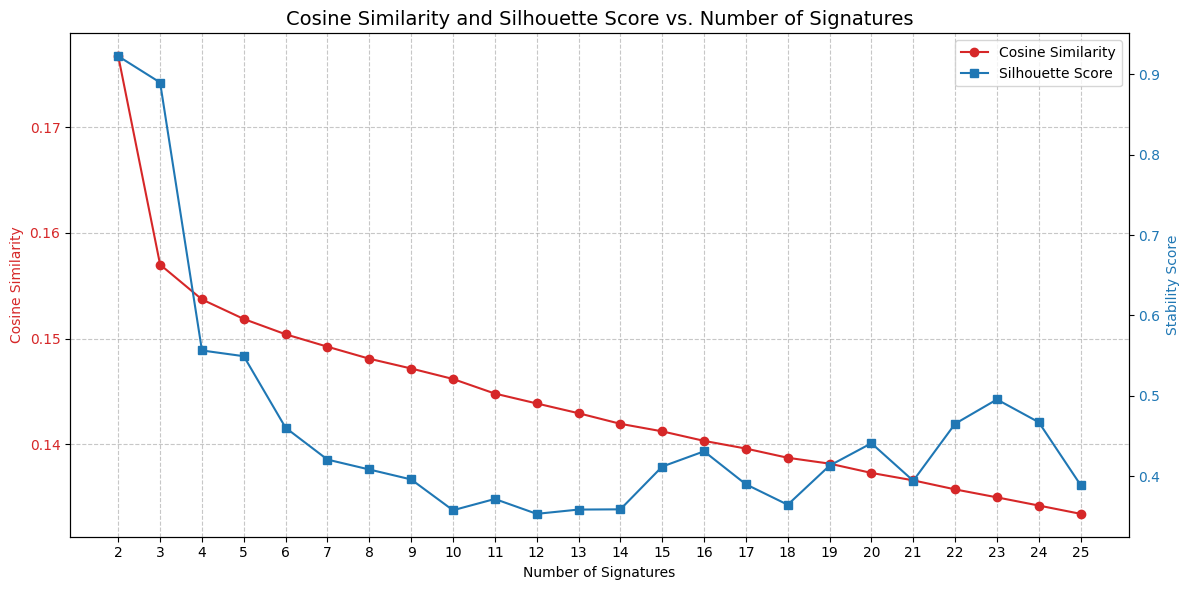

In [64]:
# plot the values of the dict KL_scores and silhouette
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a plot with primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract dimension numbers for x-axis (cleaner labels)
dim_numbers = [int(dim.split('_')[1]) for dim in KL_scores.keys()]

# Plot KL_scores on primary y-axis (left)
color1 = 'tab:red'
ax1.set_xlabel('Number of Signatures')
ax1.set_ylabel('Cosine Similarity', color=color1)
ax1.plot(dim_numbers, list(cos_scores.values()), marker='o', color=color1, label='Cosine Similarity')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.7)

# Invert y-axis for KL score so that lower (better) values are at the top
# ax1.invert_yaxis()

# Create a secondary y-axis for silhouette scores
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Stability Score', color=color2)
ax2.plot(dim_numbers, list(sil_scores.values()), marker='s', color=color2, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)

# plot a third y-axis for Frobenious norm
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # move the third y-axis outward
# color3 = 'tab:green'
# ax3.set_ylabel('Frobenius Norm', color=color3)
# ax3.plot(dim_numbers, list(forbenious.values()), marker='^', color=color3, label='Frobenius Norm')
# ax3.tick_params(axis='y', labelcolor=color3)

# Add title and legend
plt.title('Cosine Similarity and Silhouette Score vs. Number of Signatures', fontsize=14)

# Create unified legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Ensure x-axis shows integer values for dimensions
ax1.set_xticks(dim_numbers)

# Adjust layout
fig.tight_layout()


<Figure size 800x600 with 0 Axes>

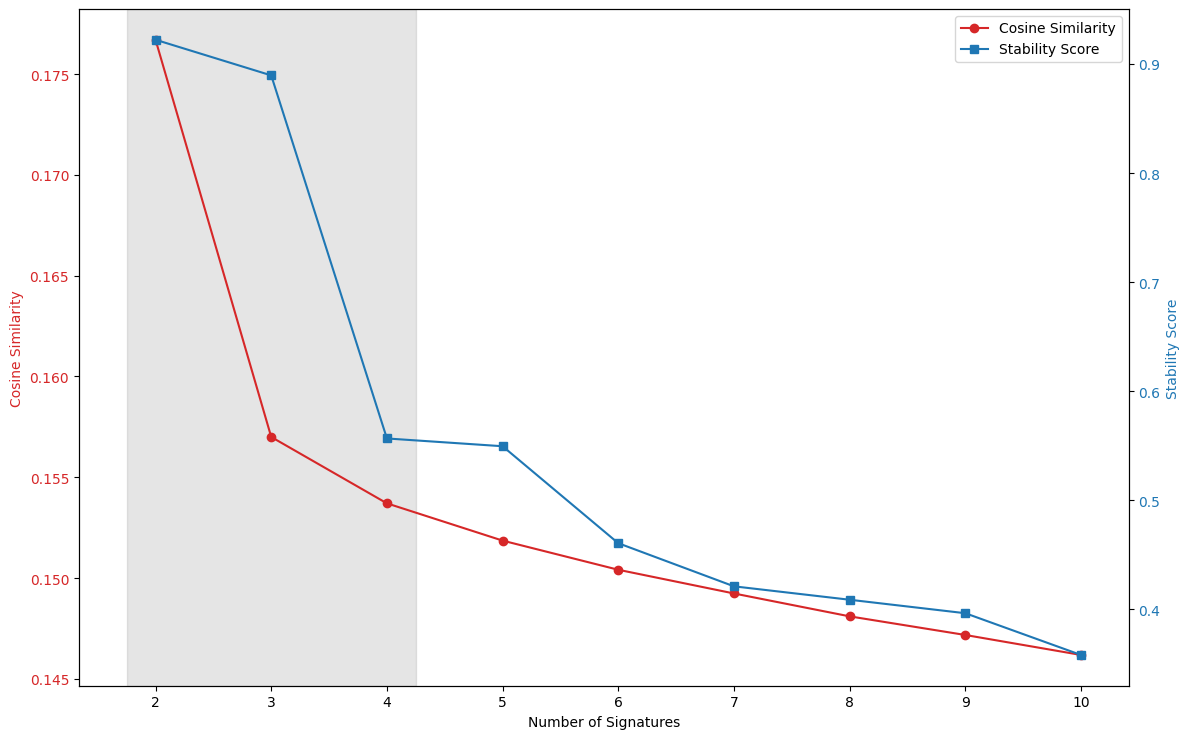

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# set size of figure
plt.figure(figsize=(8, 6))

# assume cos_scores, sil_scores, forbenious are dicts keyed 'dim_2'...'dim_25'
# first, extract the numeric dims and sort
dims_all = sorted(int(d.split('_')[1]) for d in cos_scores)
# pick only the first 10
dims = [d for d in dims_all if 2 <= d <= 10]

# pull out the corresponding y‐values
cos_vals = [cos_scores[f'dim_{d}'] for d in dims]
sil_vals = [sil_scores[f'dim_{d}'] for d in dims]

fig, ax1 = plt.subplots(figsize=(12, 7.5))

# plot cosine similarity
color1 = 'tab:red'
ax1.plot(dims, cos_vals, marker='o', color=color1, label='Cosine Similarity')
ax1.set_xlabel('Number of Signatures')
ax1.set_ylabel('Cosine Similarity', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(dims)
ax1.grid(True, linestyle='--', alpha=0.5)

# highlight around signature count = 3
ax1.axvspan(1.75, 4.25, color='grey', alpha=0.2)

# secondary axis for silhouette
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.plot(dims, sil_vals, marker='s', color=color2, label='Stability Score')
ax2.set_ylabel('Stability Score', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# unified legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

# remove grid
ax1.grid(False)
# plt.title('Cosine Similarity and Stability vs. Number of Signatures', fontsize=14)
fig.tight_layout()
plt.show()


In [66]:
# now we have determined 3 as the best nuber of dimensions, we can plot the cluster centroids
dim = 'dim_2'
path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature', dim)
exposure_path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure', dim)
files = os.listdir(path)

# filter for only .csv files
csv_files = [f for f in files if f.endswith('.csv')]

# create a list to hold the dataframes
dfs = []

# loop through the csv files and read them into dataframes
count = 1
for file in csv_files:
    df = pd.read_csv(os.path.join(path, file), index_col=0)
    df.columns = [col + '_run_' + str(count) for col in df.columns]  # replace spaces with underscores
    count += 1
    dfs.append(df)

# concatenate the dataframes into one dataframe
combined_df = pd.concat(dfs, axis = 1)


In [67]:
kmeans = KMeans(n_clusters=int(3))
kmeans.fit(df_dims[dim].T) 
cluster_centroids = kmeans.cluster_centers_


In [68]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize      import linear_sum_assignment

# pick your dim
dim = 'dim_2'
df  = df_dims[dim]           # contexts × (3×100 run-columns)
k   = 2

# 1) figure out the run-IDs (1…100) from the column names "…_run_{r}"
runs = sorted({c.rsplit('_run_',1)[1] for c in df.columns}, key=int)

# 2) collect each run's 3 signatures as a (3 × contexts) array
per_run = []
for r in runs:
    cols = [c for c in df.columns if c.endswith(f'_run_{r}')]
    # df[cols] is contexts×3 → transpose to 3×contexts
    per_run.append(df[cols].T.values)

# 3) use run#1 as the reference ordering
ref     = per_run[0]    # shape = (3, contexts)
aligned = [ref]

# 4) align runs 2…100 back to that reference
for mat in per_run[1:]:
    # build the 3×3 cost matrix of cosine distances
    cost      = cdist(ref, mat, metric='cosine')
    row_idx, col_idx = linear_sum_assignment(cost)
    # reorder 'mat' so its i-th row best matches ref[i]
    aligned.append(mat[col_idx])

# 5) stack & average to get consensus centroids
aligned_arr = np.stack(aligned, axis=0)  # shape = (100, 3, contexts)
consensus   = aligned_arr.mean(axis=0)   # shape = (3, contexts)

# 6) wrap back into a DataFrame: contexts × 3
centroid_df = pd.DataFrame(
    consensus.T,
    index=df.index,
    columns=[f'Sig{i+1}' for i in range(k)]
)

# 'centroid_df' now holds your 3 consensus signatures for dim_3


In [69]:
centroid_df


,Sig1,Sig2
_96_class,,
A[C>A]A,0.147590,0.043652
A[C>A]C,0.101559,0.016354
A[C>A]G,0.120456,0.005048
A[C>A]T,0.069223,0.003866
A[C>G]A,0.033634,0.409566
...,...,...
T[T>C]T,0.117787,0.008237
T[T>G]A,0.016143,0.010398
T[T>G]C,0.021518,0.002853


In [70]:
centroid_df.to_csv('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Harrison/mut_by_sig_dim2.tsv', sep = '\t')


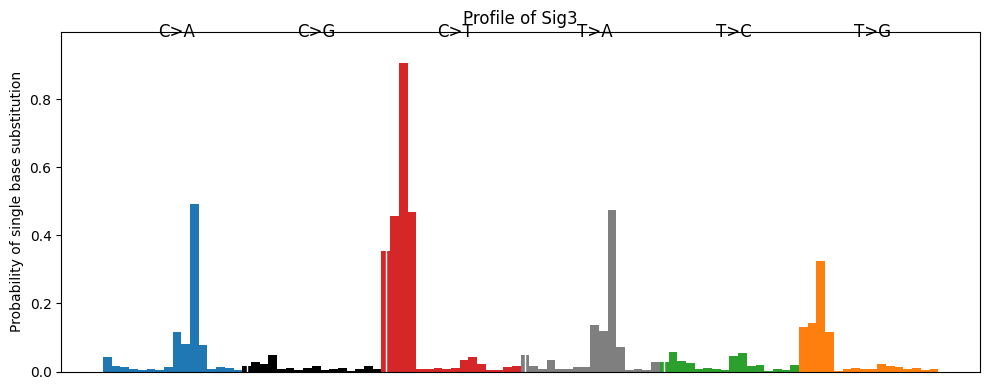

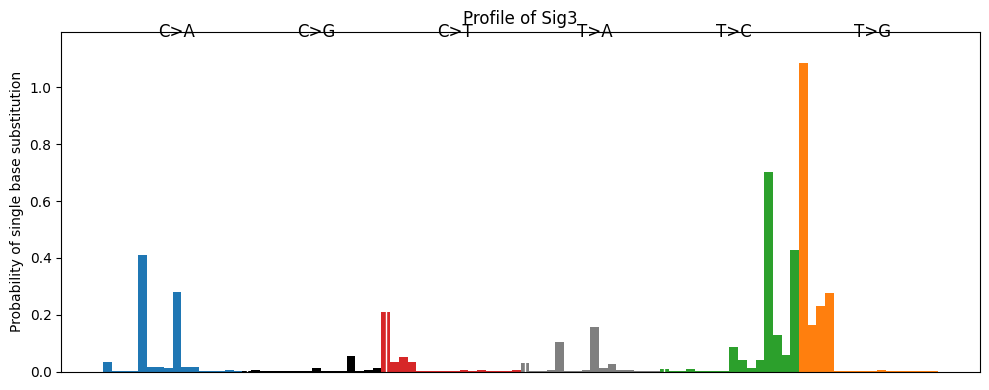

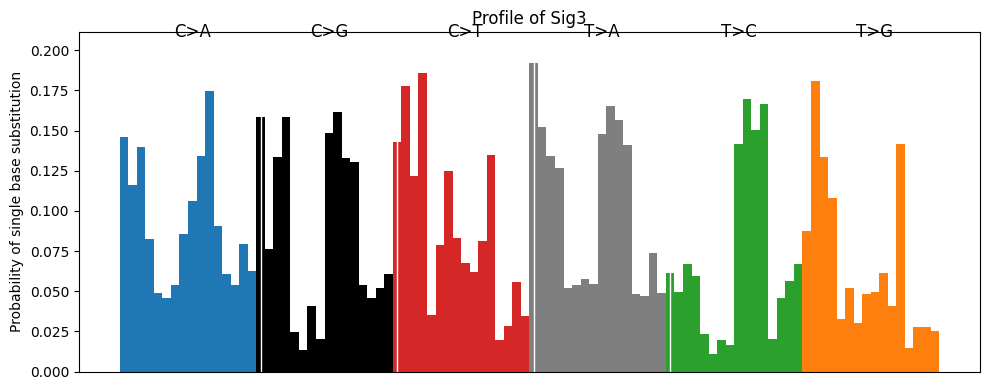

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Suppose S_cons is your consensus DataFrame (index=96 contexts, columns=['Sig1','Sig2','Sig3'])
for i in range(cluster_centroids.shape[0]):
    profile = cluster_centroids[i]#.values  # length 96

    # We’ll group them by the six substitution categories in order:
    # C>A, C>G, C>T, T>A, T>C, T>G, each of 16 contexts
    subs = ['C>A']*16 + ['C>G']*16 + ['C>T']*16 + \
           ['T>A']*16 + ['T>C']*16 + ['T>G']*16

    x = np.arange(96)
    colors = {
        'C>A':'tab:blue','C>G':'k','C>T':'tab:red',
        'T>A':'tab:gray','T>C':'tab:green','T>G':'tab:orange'
    }
    bar_colors = [colors[s] for s in subs]

    plt.figure(figsize=(10,4))
    plt.bar(x, profile, color=bar_colors, width=1.0)
    # draw the six subtype separators
    for sep in np.cumsum([16,16,16,16,16])[:-1]:
        plt.axvline(sep, color='w', linewidth=1)
    # label the six groups
    midpoints = np.cumsum([16,16,16,16,16,16]) - 8
    for i, sub in enumerate(['C>A','C>G','C>T','T>A','T>C','T>G']):
        plt.text(midpoints[i], plt.ylim()[1]*1.02, sub,
                 ha='center', va='bottom', fontsize=12)
    plt.ylim(0, profile.max()*1.1)
    plt.xticks([],[])
    plt.ylabel('Probability of single base substitution')
    plt.title(f'Profile of {sig}')
    plt.tight_layout()
    plt.show()


In [ ]:
cluster_centroids.shape


(3, 96)

In [ ]:
orig_matrix.shape


(96, 494)

In [22]:
from scipy.optimize import nnls

# M: contexts × patients (your original mutation counts)
# S_cons: contexts × 3
S_arr = cluster_centroids.T#.values
M_arr = orig_matrix.values

n_pat = M_arr.shape[1]
A_final = np.zeros((3, n_pat))

for j in range(n_pat):
    x, _ = nnls(S_arr, M_arr[:, j])
    A_final[:, j] = x

# Wrap back into a DataFrame:
A_df = pd.DataFrame(
    A_final,
    # index=cluster_centroids.columns,   # [1,2,3]
    # columns=orig_matrix.columns       # patient IDs
)


In [ ]:
A_df.columns = orig_matrix.columns
A_df.index = [1, 2, 3]
A_df


,TCGA-4P-AA8J,TCGA-BA-4074,TCGA-BA-4075,TCGA-BA-4076,TCGA-BA-4077,TCGA-BA-4078,TCGA-BA-5149,TCGA-BA-5151,TCGA-BA-5152,TCGA-BA-5153,...,TCGA-UF-A7JH,TCGA-UF-A7JJ,TCGA-UF-A7JK,TCGA-UF-A7JO,TCGA-UF-A7JS,TCGA-UF-A7JT,TCGA-UF-A7JV,TCGA-UP-A6WW,TCGA-WA-A7GZ,TCGA-WA-A7H4
1,1.206870,9.603266,4.512915,0.000000,0.000000,0.000000,4.888176,8.653363,2.962812,3.470964,...,6.188786,0.317919,10.397392,15.597370,4.760863,10.978753,1.156235,4.840940,8.296450,2.550567
2,10.618779,4.574356,2.531583,3.501733,48.631013,8.815269,4.944108,2.380734,110.385512,0.613445,...,1.541417,0.000000,0.407386,13.311082,2.285508,25.396035,12.750550,0.295964,18.426190,3.437697
3,10.830573,9.858212,9.819901,45.566826,10.579219,65.239306,8.271517,4.017069,2.021722,2.553627,...,6.043191,6.273752,7.950650,2.750157,3.781062,4.103106,2.324499,1.802874,11.240878,1.950525


In [ ]:
A_df.to_csv('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Harrison/mut_x_patient.csv', sep=',')
